# Verwenden statistischer Größen der Zeitreihen als Features

Nun Einbeziehen der Quantile statt nur Median und Max.

Zusätzlich Zeitpunkt des Knicks

- Test SVM-Klassifikation, Hyperparameter epsilon
- zusätzlich Test von HalvingGridSearchCV

In [1]:
import io, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import scipy
from sklearn.experimental import enable_halving_search_cv
from sklearn import model_selection, svm, metrics, manifold, preprocessing
import joblib

import prepare

In [2]:
BASE_DIR = 'renamed'
DATA_OK = ['ok', 'near_ok_sonowechsel']
DATA_FEHLER = ['fehler_oel', 'fehler_leitungsversatz', 'fehler_terminversatz']
DATA_ALL = DATA_OK + DATA_FEHLER

In [3]:
DATA_ALL

['ok',
 'near_ok_sonowechsel',
 'fehler_oel',
 'fehler_leitungsversatz',
 'fehler_terminversatz']

In [4]:
zugversuche, kurven = prepare.read_all(BASE_DIR, DATA_ALL)

ok_: count 200 rows 1407...1650
near_ok_sonowechsel_: count 100 rows 1582...1759
fehler_oel_: count 100 rows 1052...1434
fehler_leitungsversatz_: count 100 rows 1716...2403
fehler_terminversatz_: count 100 rows 1702...2092


Debugausgabe

In [5]:
zugversuche

,nr,festigkeit,key,label,label_text
0,1569,2600.000000,ok_1569,0,ok
1,1570,2750.000000,ok_1570,0,ok
2,1571,2770.000000,ok_1571,0,ok
3,1572,2660.000000,ok_1572,0,ok
4,1573,2810.000000,ok_1573,0,ok
...,...,...,...,...,...
595,2505,1479.522827,fehler_terminversatz_2505,4,fehler_terminversatz
596,2506,2085.117920,fehler_terminversatz_2506,4,fehler_terminversatz
597,2507,2237.231201,fehler_terminversatz_2507,4,fehler_terminversatz
598,2508,2406.469482,fehler_terminversatz_2508,4,fehler_terminversatz


In [6]:
versuche_train, versuche_test = model_selection.train_test_split(zugversuche, test_size=0.2, random_state=42)
versuche_train.shape, versuche_test.shape

((480, 5), (120, 5))

Umwandeln in statistische Features

In [7]:
stat_feat = prepare.StatFeatures3()
stat_feat.fit() # dummy

StatFeatures3()

In [8]:
X_train = stat_feat.transform(versuche_train.key, kurven)
label_train = versuche_train.label.values
festigkeit_train = versuche_train.festigkeit.values
print(X_train.shape, label_train.shape)

(480, 25) (480,)


In [38]:
df_train = pd.DataFrame(X_train)
df_train.columns = ['p_mean', 'p_q25', 'p_q50', 'p_q75', 'p_max', 'p_std', 'p_b50', 'p_b75',
                    'f_mean', 'f_q25', 'f_q50', 'f_q75', 'f_max', 'f_std', 'f_b50', 'f_b75',
                    'd_mean', 'd_q25', 'd_q50', 'd_q75', 'd_max', 'd_std', 'd_b50', 'd_b75',
                    'ti']
df_train

,p_mean,p_q25,p_q50,p_q75,p_max,p_std,p_b50,p_b75,f_mean,f_q25,...,f_b75,d_mean,d_q25,d_q50,d_q75,d_max,d_std,d_b50,d_b75,ti
0,2162.399150,2177.11,2206.72,2239.07,2320.55,268.131180,29.0,53.0,562.086546,557.878,...,2.0,1.588280,1.30000,1.61,1.95,2.34000,0.459939,252.0,923.0,1512.0
1,2168.165892,2169.56,2208.93,2248.60,2354.81,266.021570,28.0,48.0,542.749119,534.196,...,2.0,1.613718,1.36000,1.66,1.95,2.28000,0.433425,194.0,821.0,1508.0
2,2996.073461,2939.05,3097.13,3309.54,3536.60,562.623502,51.0,104.0,563.949863,555.925,...,2.0,1.477104,1.37000,1.55,1.68,1.90000,0.326417,80.0,332.0,1091.0
3,1722.829645,1710.68,1737.84,1777.51,1910.57,186.695972,28.0,44.0,554.044990,546.159,...,2.0,1.834555,1.49000,1.85,2.25,2.70000,0.520232,310.0,1150.0,1897.0
4,2126.949185,2127.50,2164.43,2203.80,2332.28,262.580164,29.0,48.0,558.246897,552.019,...,2.0,1.704925,1.45000,1.75,2.04,2.38000,0.438428,175.0,817.0,1537.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,2090.777070,2089.24,2126.17,2165.84,2274.49,249.642936,28.0,45.0,551.002387,546.159,...,2.0,1.746961,1.51000,1.79,2.07,2.37000,0.421186,139.0,755.0,1563.0
476,2111.946138,2102.80,2144.61,2196.49,2334.74,262.156992,30.0,50.0,554.632226,550.066,...,2.0,1.771536,1.50999,1.81,2.12,2.47000,0.452470,169.0,835.0,1548.0
477,1943.238719,1927.70,1969.51,2020.78,2167.27,233.848258,30.0,51.0,569.291787,561.785,...,2.0,1.616360,1.40000,1.67,1.91,2.16000,0.383402,143.0,744.0,1682.0
478,1837.798535,1953.99,2018.38,2050.42,2109.63,447.167900,192.0,258.0,553.539707,548.112,...,2.0,2.853262,2.62500,3.09,3.39,3.67001,0.781532,189.0,542.0,1779.0


In [9]:
X_test = stat_feat.transform(versuche_test.key, kurven)
label_test = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values
print(X_test.shape)
print(X_test.max(axis=(0,1)))
#festigkeit_train

(120, 25)
3551.38


Skalieren Trainingsdaten

In [10]:
std_scaler = preprocessing.StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train)

Skalieren Testdaten

In [11]:
X_test_scaled = std_scaler.transform(X_test)

Stärke der Korrelation der Features zur Zielgröße

In [13]:
# erstmal DataFrame mit Features und Zielgröße aufbauen
df_train = pd.DataFrame(X_train_scaled)
df_train.columns = ['p_mean', 'p_q25', 'p_q50', 'p_q75', 'p_max', 'p_std', 'p_b50', 'p_b75',
                    'f_mean', 'f_q25', 'f_q50', 'f_q75', 'f_max', 'f_std', 'f_b50', 'f_b75',
                    'd_mean', 'd_q25', 'd_q50', 'd_q75', 'd_max', 'd_std', 'd_b50', 'd_b75',
                    'ti']
df_train['festigkeit'] = festigkeit_train

In [14]:
corr = df_train.corr()
corr['festigkeit'].abs().sort_values(ascending=False)

festigkeit    1.000000
p_max         0.861549
p_q75         0.834543
p_q50         0.812366
p_mean        0.795196
p_q25         0.765958
ti            0.676238
p_std         0.663320
f_std         0.625415
f_max         0.487235
f_q75         0.453694
d_b75         0.443619
d_max         0.424856
d_q75         0.387241
d_std         0.376086
d_mean        0.353475
d_q50         0.319570
f_q50         0.302010
d_b50         0.280804
f_mean        0.277208
d_q25         0.270749
f_q25         0.148749
p_b50         0.088505
p_b75         0.005782
f_b50              NaN
f_b75              NaN
Name: festigkeit, dtype: float64

Kontrollanzeige t-SNE

In [15]:
X_train_projected = manifold.TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(X_train_scaled)

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Klassen')

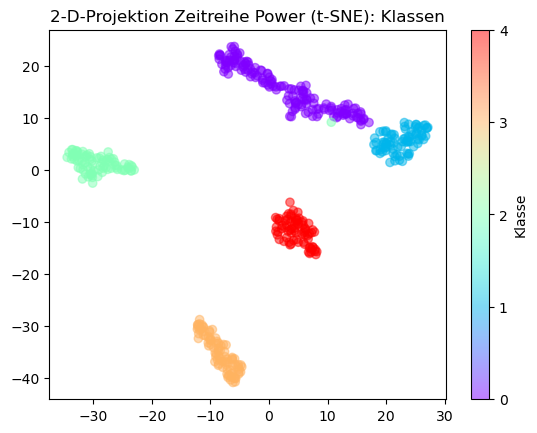

In [16]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], c=label_train, cmap='rainbow', alpha=0.5)
plt.colorbar(label='Klasse', ticks=[0,1,2,3,4,5])
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Klassen')

Text(0.5, 1.0, '2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

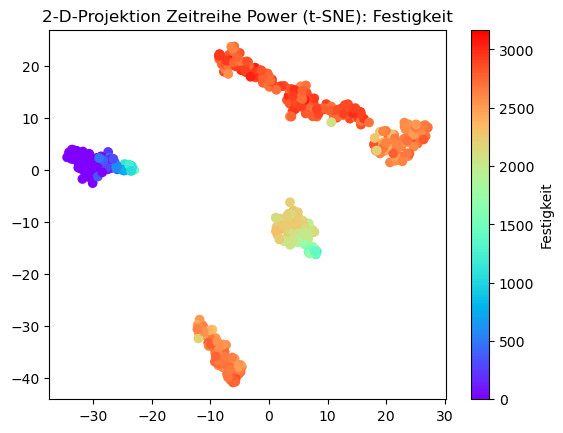

In [17]:
plt.scatter(X_train_projected[:,0], X_train_projected[:,1], c=festigkeit_train, cmap='rainbow')
plt.colorbar(label='Festigkeit')
plt.title('2-D-Projektion Zeitreihe Power (t-SNE): Festigkeit')

Kernel-SVM (Klassifikation) mit Random Search

In [18]:
params = {
    #'C': scipy.stats.expon(100),
    #'gamma': scipy.stats.expon(0.01),
    'C': np.logspace(0, 4),      # 50 Werte zwischen 1 und 10000
    'gamma': np.logspace(-5, 1), # 50 Werte zwischen 1e-5 und 10
}
estim_search = model_selection.RandomizedSearchCV(
    svm.SVC(),
    params,
    n_iter=50,
)
_ = estim_search.fit(X_train_scaled, label_train)
estimator = estim_search.best_estimator_
print(estim_search.best_params_)

{'gamma': 0.2559547922699533, 'C': 35.564803062231285}


Accuracy

In [19]:
score_train = estimator.score(X_train_scaled, label_train)
score_test = estimator.score(X_test_scaled, label_test)
score_train, score_test

(1.0, 1.0)

Anzeige Confusion Matrix (Testdaten)

In [20]:
def plot_confusion(y_true, y_pred):
    conf = metrics.confusion_matrix(y_true, y_pred)
    metrics.ConfusionMatrixDisplay(conf).plot()

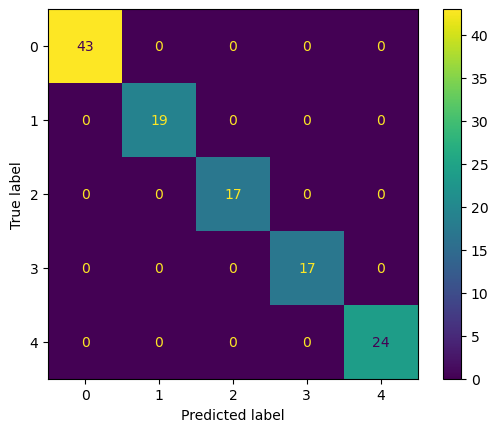

In [21]:
pred_test = estimator.predict(X_test_scaled)
disp = plot_confusion(label_test, pred_test)
plt.savefig('svc_test_confusion.png')

SVM-Regressor (Standardparameter)

In [22]:
regr = svm.SVR()
_= regr.fit(X_train_scaled, festigkeit_train)

Vorhersage Trainingsdaten

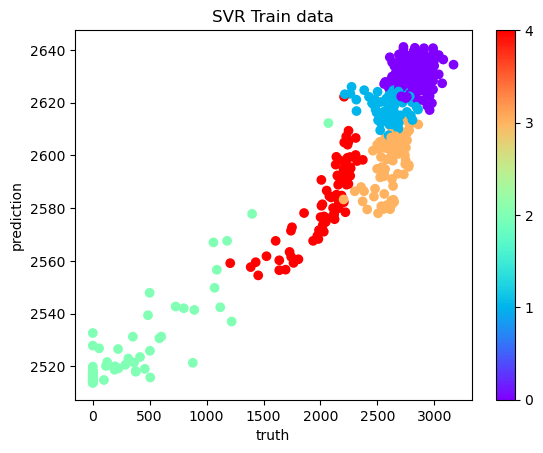

In [23]:
y_pred_train = regr.predict(X_train_scaled)
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.title('SVR Train data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('svr_train.png')

Vorhersage Testdaten

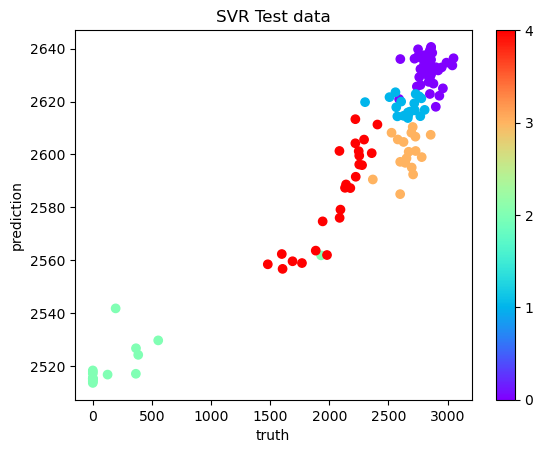

In [24]:
y_pred_test = regr.predict(X_test_scaled)
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5))
plt.savefig('svr_test.png')

In [25]:
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")


MSE: train 999164.7, test: 861444.9
RMSE: train    999.6 test:    928.1
MAE: train    578.0, test:    532.8


In [26]:
params = {
    #'C': scipy.stats.expon(100),
    #'gamma': scipy.stats.expon(0.01),
    'C': np.logspace(0, 5),      # 50 Werte zwischen 1 und 10000
    'gamma': np.logspace(-5, 1), # 50 Werte zwischen 1e-5 und 10
    'epsilon': np.logspace(-2, 2) # 50 Werte zwischen 0.01 und 100
}
# experimental, results not very stable!
estim2 = model_selection.HalvingRandomSearchCV(
    svm.SVR(),
    params,
    n_candidates='exhaust',
    factor=2,
    #verbose=3,
)
# alternativ RandomSearch
estim3 = model_selection.RandomizedSearchCV(
    svm.SVR(),
    params,
    n_iter=500, # ATTENTION: runs very long
    n_jobs=-1,
)
estim3.fit(X_train_scaled, festigkeit_train)
print('Best parameters:', estim3.best_params_)
best_estim = estim3.best_estimator_


Best parameters: {'gamma': 0.03556480306223128, 'epsilon': 56.89866029018293, 'C': 15264.179671752334}


*Beobachtung*: sehr großer Wert für *C*.

Eventuell Verbesserung durch Skalieren der Zielgröße (statt `festigkeit` besser `festigkeit/2000` vorhersagen?

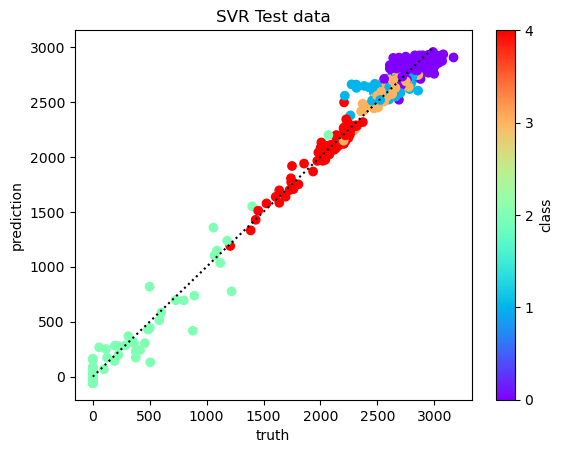

In [27]:
y_pred_train = best_estim.predict(X_train_scaled)
plt.scatter(festigkeit_train, y_pred_train, c=label_train, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5), label='class')
#plt.savefig('svr_randsearch_train.png')

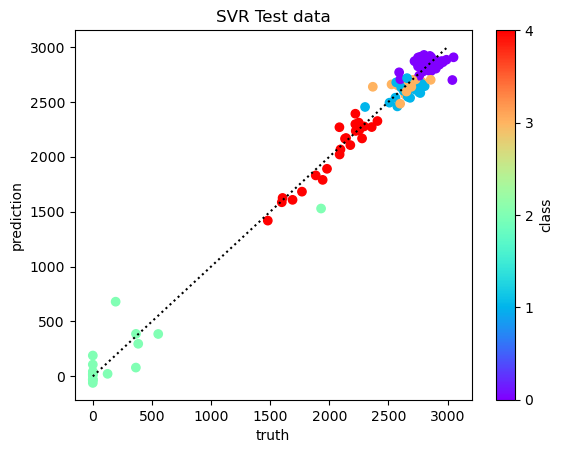

In [28]:
y_pred_test = best_estim.predict(X_test_scaled)
plt.scatter(festigkeit_test, y_pred_test, c=label_test, cmap='rainbow')
plt.plot([0, 3000], [0,3000], "k:")
plt.title('SVR Test data')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.colorbar(ticks=np.arange(5), label='class')
#plt.savefig('svr_randsearch_test.png')

In [29]:
y_pred_train = best_estim.predict(X_train_scaled)
y_pred_test = best_estim.predict(X_test_scaled)
mse_train = metrics.mean_squared_error(festigkeit_train, y_pred_train)
mse_test = metrics.mean_squared_error(festigkeit_test, y_pred_test)
print(f"MSE: train {mse_train:8.1f}, test: {mse_test:8.1f}")
print(f"RMSE: train {np.sqrt(mse_train):8.1f} test: {np.sqrt(mse_test):8.1f}")
mae_train = metrics.mean_absolute_error(festigkeit_train, y_pred_train)
mae_test = metrics.mean_absolute_error(festigkeit_test, y_pred_test)
print(f"MAE: train {mae_train:8.1f}, test: {mae_test:8.1f}")
# mapi ist nutzlos durch 0-Werte bei Zugfestigkeit
#mapi_train = metrics.mean_absolute_percentage_error(festigkeit_train, y_pred_train)
#mapi_test = metrics.mean_absolute_percentage_error(festigkeit_test, y_pred_test)
#print(f"MAPI: train {mapi_train:8.1f}, test: {mapi_test:8.1f}")



MSE: train   9081.3, test:  12744.3
RMSE: train     95.3 test:    112.9
MAE: train     70.4, test:     82.2
